<a href="https://colab.research.google.com/github/VladimirVladetic/OSiRV-RoadSignDetection/blob/main/EDA_Training_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
def remove_images_with_zero_dimensions(images_array, class_label_array, bbox_array):
    indices_to_remove = []
    for i, image in enumerate(images_array):
        height, width, channels = image.shape
        if height == 0 or width == 0:
            indices_to_remove.append(i)
    images_array = np.delete(images_array, indices_to_remove, axis=0)
    class_label_array = np.delete(class_label_array, indices_to_remove, axis=0)
    bbox_array = np.delete(bbox_array, indices_to_remove, axis=0)

    return images_array, class_label_array, bbox_array, indices_to_remove

In [4]:
from skimage import feature

def extract_features_edge(images, height, width):
    features = []
    for var_img  in tqdm(images):

        edge_channels = [feature.canny(var_img[:, :, i]) for i in range(3)]
        edges = np.stack(edge_channels, axis=-1)
        edges_image = Image.fromarray(edges.astype(np.uint8) * 255)
        edges_image = edges_image.resize((height, width), Image.ANTIALIAS)
        edges_image = np.array(edges_image)
        edges_image = edges_image / 255.0
        features.append(edges_image)

    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [5]:
from skimage import feature

def extract_features_edge_with_padding(images, height, width):
    features = []
    for var_img  in tqdm(images):

        padding_needed = False
        if var_img.shape[0] < height or var_img.shape[1] < width:
            padding_needed = True
        if padding_needed:
            pad_height = max(0, height - var_img.shape[0])
            pad_width = max(0, width - var_img.shape[1])
            top_pad = pad_height // 2
            bottom_pad = pad_height - top_pad
            left_pad = pad_width // 2
            right_pad = pad_width - left_pad
            var_img = np.pad(var_img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode='constant')

        edge_channels = [feature.canny(var_img[:, :, i]) for i in range(3)]
        edges = np.stack(edge_channels, axis=-1)
        edges_image = Image.fromarray(edges.astype(np.uint8) * 255)
        edges_image = edges_image.resize((height, width), Image.ANTIALIAS)
        edges_image = np.array(edges_image)
        edges_image = edges_image / 255.0
        features.append(edges_image)

    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [ ]:
from skimage.morphology import erosion, dilation
from PIL import Image
from skimage import feature

def extract_features_dilation(images, height, width):
    features = []
    for var_img in tqdm(images):

        dilated = dilation(var_img)
        dilated = (dilated * 255).astype(np.uint8)
        var_image = Image.fromarray(dilated)
        var_image = var_image.resize((height, width), Image.ANTIALIAS)
        var_image = np.array(var_image) / 255.0
        features.append(var_image)

    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [ ]:
from skimage.morphology import erosion, dilation
from PIL import Image
from skimage import feature

def extract_features_dilation_with_padding(images, height, width):
    features = []
    for var_img in tqdm(images):

        padding_needed = False
        if var_img.shape[0] < height or var_img.shape[1] < width:
            padding_needed = True
        if padding_needed:
            pad_height = max(0, height - var_img.shape[0])
            pad_width = max(0, width - var_img.shape[1])
            top_pad = pad_height // 2
            bottom_pad = pad_height - top_pad
            left_pad = pad_width // 2
            right_pad = pad_width - left_pad
            var_img = np.pad(var_img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode='constant')

        dilated = dilation(var_img)
        dilated = (dilated * 255).astype(np.uint8)
        var_image = Image.fromarray(dilated)
        var_image = var_image.resize((height, width), Image.ANTIALIAS)
        var_image = np.array(var_image) / 255.0
        features.append(var_image)

    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [6]:
from skimage.morphology import erosion, dilation
from PIL import Image
from skimage import feature

def extract_features_erosion(images, height, width):
    features = []
    for var_img in tqdm(images):

        eroded = erosion(var_img)
        # dilated = dilation(eroded)
        eroded = (eroded * 255).astype(np.uint8)
        var_image = Image.fromarray(eroded)
        var_image = var_image.resize((height, width), Image.ANTIALIAS)
        var_image = np.array(var_image) / 255.0
        features.append(var_image)

    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [7]:
from skimage.morphology import erosion, dilation
from PIL import Image
from skimage import feature

def extract_features_erosion_with_padding(images, height, width):
    features = []
    for var_img in tqdm(images):

        padding_needed = False
        if var_img.shape[0] < height or var_img.shape[1] < width:
            padding_needed = True
        if padding_needed:
            pad_height = max(0, height - var_img.shape[0])
            pad_width = max(0, width - var_img.shape[1])
            top_pad = pad_height // 2
            bottom_pad = pad_height - top_pad
            left_pad = pad_width // 2
            right_pad = pad_width - left_pad
            var_img = np.pad(var_img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode='constant')

        eroded = erosion(var_img)
        # dilated = dilation(eroded)
        eroded = (eroded * 255).astype(np.uint8)
        var_image = Image.fromarray(eroded)
        var_image = var_image.resize((height, width), Image.ANTIALIAS)
        var_image = np.array(var_image) / 255.0
        features.append(var_image)

    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [8]:
from PIL import ImageOps

def extract_features_contrast(images, height, width):
    features = []
    for image in tqdm(images):

        var_img = Image.fromarray(image, mode='RGB')
        var_img = ImageOps.equalize(var_img, mask=None) ## Contrast enhancement
        var_img = var_img.resize((height,width), Image.ANTIALIAS)
        var_img = np.array(var_img)
        var_img = var_img / 255.0
        features.append(var_img)
    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [9]:
from PIL import ImageOps

def extract_features_contrast_with_padding(images, height, width):
    features = []
    for image in tqdm(images):

        padding_needed = False
        if var_img.shape[0] < height or var_img.shape[1] < width:
            padding_needed = True
        if padding_needed:
            pad_height = max(0, height - var_img.shape[0])
            pad_width = max(0, width - var_img.shape[1])
            top_pad = pad_height // 2
            bottom_pad = pad_height - top_pad
            left_pad = pad_width // 2
            right_pad = pad_width - left_pad
            var_img = np.pad(var_img, ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)), mode='constant')

        var_img = Image.fromarray(image, mode='RGB')
        var_img = ImageOps.equalize(var_img, mask=None) ## Contrast enhancement
        var_img = var_img.resize((height,width), Image.ANTIALIAS)
        var_img = np.array(var_img)
        var_img = var_img / 255.0
        features.append(var_img)
    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [ ]:
! pip install pybboxes
! pip install kaggle

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import zipfile
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
import shutil
from imblearn.under_sampling import RandomUnderSampler
import xml.etree.ElementTree as ET
import pybboxes as pbx
from collections import defaultdict
from google.colab import files

In [ ]:
uploaded = files.upload()

source_path = '/content/kaggle.json'
destination_path = '/root/.kaggle/kaggle.json'
kaggle_dir = '/root/.kaggle/'
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
os.rename(source_path, destination_path)

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d andrewmvd/road-sign-detection
with zipfile.ZipFile('/content/road-sign-detection.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

 95% 208M/218M [00:02<00:00, 110MB/s] 
100% 218M/218M [00:02<00:00, 105MB/s]


In [ ]:
annotations_path = '/content/annotations'
annotations = os.listdir(annotations_path)

In [ ]:
img_name_list = []
width_list = []
height_list = []
label_list = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []
bboxes = []

for idx in tqdm(range(len(annotations))):

    tree = ET.parse(os.path.join(annotations_path, annotations[idx]))
    root = tree.getroot()

    img_name = root.find('filename').text

    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text

    for group in root.findall('object'):
        label = group.find('name').text
        bbox = group.find('bndbox')
        xmin = bbox.find('xmin').text
        ymin = bbox.find('ymin').text
        xmax = bbox.find('xmax').text
        ymax = bbox.find('ymax').text

        img_name_list.append("/content/images/" + img_name)
        width_list.append(width)
        height_list.append(height)
        xmin_list.append(xmin)
        ymin_list.append(ymin)
        xmax_list.append(xmax)
        ymax_list.append(ymax)
        label_list.append(label)
        bboxes.append((xmin,ymin,xmax,ymax))

  0%|          | 0/877 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame({
                        'image_path': img_name_list,
                        'width': width_list,
                        'height': height_list,
                        'xmin': xmin_list,
                        'ymin': ymin_list,
                        'xmax': xmax_list,
                        'ymax': ymax_list,
                        'bboxes': bboxes,
                        'class_label': label_list})

classes = df['class_label'].unique().tolist()
classes

df['class_int'] = df['class_label'].apply(lambda x: classes.index(x))
print(df.shape)
df.head()

(1244, 10)


,image_path,width,height,xmin,ymin,xmax,ymax,bboxes,class_label,class_int
0,/content/images/road757.png,300,400,108,152,140,181,"(108, 152, 140, 181)",speedlimit,0
1,/content/images/road389.png,300,400,178,100,221,143,"(178, 100, 221, 143)",speedlimit,0
2,/content/images/road866.png,300,400,56,150,103,195,"(56, 150, 103, 195)",speedlimit,0
3,/content/images/road528.png,300,400,86,191,134,244,"(86, 191, 134, 244)",speedlimit,0
4,/content/images/road528.png,300,400,0,1,168,87,"(0, 1, 168, 87)",crosswalk,1


In [ ]:
from sklearn.preprocessing import LabelBinarizer

width = 224
height = 224
og_height = 400
og_width = 300

width_scale = width / og_width
height_scale = height / og_height

lb = LabelBinarizer()

images_array = []

image_paths = np.array(df['image_path'])

for image_path in image_paths:
    image = load_img(image_path, target_size=(height, width))
    image = img_to_array(image)
    images_array.append(np.array(image) / 255)

class_label_array = np.array(df['class_int'])
class_label_array = lb.fit_transform(class_label_array)

bbox_array = np.array(df['bboxes'])
bbox_array = np.array([list(map(float, box)) for box in bbox_array])
for bbox in bbox_array:
    bbox[0] *= width_scale
    bbox[1] *= height_scale
    bbox[2] *= width_scale
    bbox[3] *= height_scale

images_array, class_label_array, bbox_array, removed_indices = remove_images_with_zero_dimensions(images_array, class_label_array, bbox_array)

In [ ]:
from sklearn.model_selection import train_test_split

trainImages, testImages, trainLabels, testLabels, trainBBoxes, testBBoxes, trainPaths, testPaths = train_test_split(
                         images_array,
                         class_label_array,
                         bbox_array,
                         image_paths,
                         test_size=0.2,
                         random_state=42)


In [ ]:
first_image = trainImages[0]
print(type(first_image))
print(first_image.shape)

<class 'numpy.ndarray'>
(224, 224, 3)


In [ ]:
from tensorflow.keras.applications import VGG16

vgg = VGG16(weights="imagenet",
            include_top=False,
            input_tensor=Input(shape=(224, 224, 3)))

vgg.trainable = False

flatten = vgg.output
flatten = Flatten()(flatten)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Input

resnet = ResNet50(weights="imagenet",
                  include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))
resnet.trainable = False
flatten = resnet.output
flatten = Flatten()(flatten)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten, Input

inception = InceptionV3(weights="imagenet",
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))
inception.trainable = False
flatten = inception.output
flatten = Flatten()(flatten)

In [ ]:
features = extract_features_erosion(trainImages,height,width)

  0%|          | 0/995 [00:00<?, ?it/s]

In [ ]:
from tensorflow.keras import regularizers

bboxHead = Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01))(flatten)
bboxHead = Dropout(0.3)(bboxHead)
bboxHead = Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01))(bboxHead)
bboxHead = Dropout(0.3)(bboxHead)
bboxHead = Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01))(bboxHead)
bboxHead = Dropout(0.3)(bboxHead)
bboxHead = Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01))(bboxHead)
bboxHead = Dense(4, activation="linear")(bboxHead)

In [ ]:
bboxmodel = Model(
    inputs=resnet.input,
    outputs=bboxHead)

In [ ]:
bboxmodel.summary()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

INIT_LR = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 16

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lr = ReduceLROnPlateau(factor=0.25, patience=3)

In [ ]:
opt = Adam(INIT_LR)

bboxmodel.compile(loss="mean_absolute_error",
              optimizer=opt,
              metrics=["accuracy"])

In [ ]:
history = bboxmodel.fit(
    features, trainBBoxes,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping,lr],
    verbose=1)

Epoch 1/100
50/50 [==============================] - 12s 139ms/step - loss: 75.8078 - accuracy: 0.4899 - val_loss: 45.3008 - val_accuracy: 0.5276 - lr: 1.0000e-04
Epoch 2/100
50/50 [==============================] - 5s 108ms/step - loss: 49.0007 - accuracy: 0.4824 - val_loss: 43.8903 - val_accuracy: 0.5176 - lr: 1.0000e-04
Epoch 3/100
50/50 [==============================] - 5s 97ms/step - loss: 47.6451 - accuracy: 0.4849 - val_loss: 44.1929 - val_accuracy: 0.4724 - lr: 1.0000e-04
Epoch 4/100
50/50 [==============================] - 5s 108ms/step - loss: 46.3465 - accuracy: 0.5101 - val_loss: 42.9563 - val_accuracy: 0.4724 - lr: 1.0000e-04
Epoch 5/100
50/50 [==============================] - 5s 97ms/step - loss: 45.8086 - accuracy: 0.5075 - val_loss: 43.5023 - val_accuracy: 0.4724 - lr: 1.0000e-04
Epoch 6/100
50/50 [==============================] - 5s 97ms/step - loss: 45.1261 - accuracy: 0.4950 - val_loss: 45.5872 - val_accuracy: 0.4724 - lr: 1.0000e-04
Epoch 7/100
50/50 [===========

In [ ]:
first_image = trainImages[0]
print(type(first_image))
print(first_image.shape)

<class 'numpy.ndarray'>
(224, 224, 3)


In [ ]:
def crop_images(images, bboxes):
    cropped_images = []
    for image, bbox in zip(images, bboxes):

        xmin, ymin, xmax, ymax = bbox
        xmin = max(0, int(xmin))
        ymin = max(0, int(ymin))
        xmax = min(image.shape[1], int(xmax))
        ymax = min(image.shape[0], int(ymax))
        cropped_image = image[ymin:ymax, xmin:xmax, :]
        cropped_images.append(cropped_image)

    return cropped_images

In [ ]:
trainImages = crop_images(trainImages, trainBBoxes)

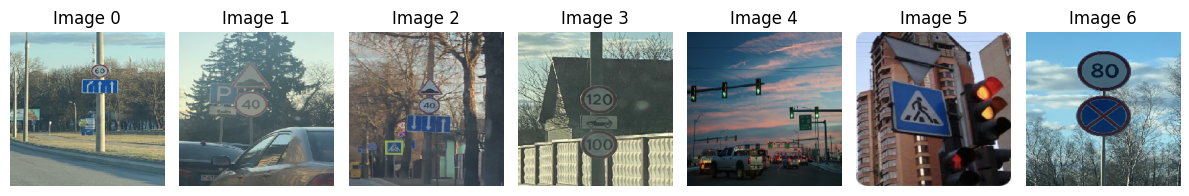

In [ ]:
import matplotlib.pyplot as plt
indices_to_display = [0, 1, 2, 3, 4, 5, 6]
fig, axes = plt.subplots(1, 7, figsize=(12, 4))

for i, idx in enumerate(indices_to_display):
    image = trainImages[idx]
    axes[i].imshow(image)
    axes[i].set_title(f'Image {idx}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
features = extract_features_erosion(trainImages,32,32)

  0%|          | 0/995 [00:00<?, ?it/s]

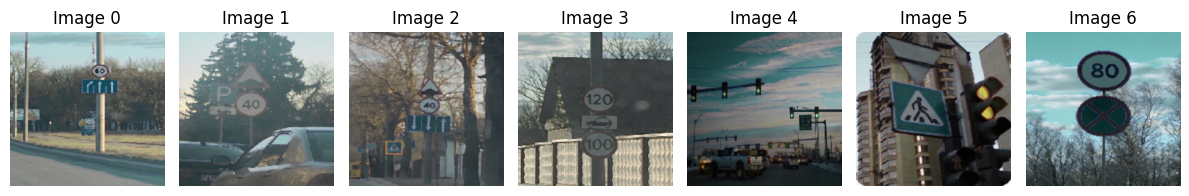

In [ ]:
import matplotlib.pyplot as plt
indices_to_display = [0, 1, 2, 3, 4, 5, 6]
fig, axes = plt.subplots(1, 7, figsize=(12, 4))

for i, idx in enumerate(indices_to_display):
    image = features[idx]
    axes[i].imshow(image)
    axes[i].set_title(f'Image {idx}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Input

resnet = ResNet50(weights="imagenet",
                  include_top=False,
                  input_tensor=Input(shape=(32, 32, 3)))
resnet.trainable = False
flatten = resnet.output
flatten = Flatten()(flatten)

In [ ]:
softmaxHead = Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01))(flatten)
softmaxHead = Dropout(0.3)(softmaxHead)
softmaxHead = Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01))(softmaxHead)
softmaxHead = Dropout(0.3)(softmaxHead)
softmaxHead = Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01))(softmaxHead)
softmaxHead = Dropout(0.3)(softmaxHead)
softmaxHead = Dense(256, activation="relu")(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

In [ ]:
clasificationmodel = Model(
    inputs=resnet.input,
    outputs=softmaxHead)

In [ ]:
INIT_LR = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 16

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lr = ReduceLROnPlateau(factor=0.5, patience=5)

In [ ]:
opt = Adam(INIT_LR)

clasificationmodel.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [ ]:
history = clasificationmodel.fit(
    features, trainLabels,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping,lr],
    verbose=1)

Epoch 1/100
50/50 [==============================] - 14s 157ms/step - loss: 1.2035 - accuracy: 0.5653 - val_loss: 1.0720 - val_accuracy: 0.6131 - lr: 1.0000e-04
Epoch 2/100
50/50 [==============================] - 5s 105ms/step - loss: 1.0958 - accuracy: 0.6030 - val_loss: 1.1215 - val_accuracy: 0.6131 - lr: 1.0000e-04
Epoch 3/100
50/50 [==============================] - 7s 138ms/step - loss: 1.0865 - accuracy: 0.6055 - val_loss: 1.0843 - val_accuracy: 0.6131 - lr: 1.0000e-04
Epoch 4/100
50/50 [==============================] - 6s 113ms/step - loss: 1.0322 - accuracy: 0.6344 - val_loss: 1.1035 - val_accuracy: 0.6181 - lr: 1.0000e-04
Epoch 5/100
50/50 [==============================] - 7s 133ms/step - loss: 1.0217 - accuracy: 0.6244 - val_loss: 1.0411 - val_accuracy: 0.6131 - lr: 1.0000e-04
Epoch 6/100
50/50 [==============================] - 5s 105ms/step - loss: 1.0081 - accuracy: 0.6332 - val_loss: 1.1152 - val_accuracy: 0.5427 - lr: 1.0000e-04
Epoch 7/100
50/50 [====================

In [ ]:
import matplotlib.pyplot as plt
indices_to_display = [0, 1, 2, 3, 4]
fig, axes = plt.subplots(1, 5, figsize=(12, 4))

for i, idx in enumerate(indices_to_display):
    image = features[idx]
    axes[i].imshow(image)
    axes[i].set_title(f'Image {idx}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class_counts = df['class_label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['width'], bins=30, color='purple', edgecolor='black')
plt.title('Distribution of Image Width')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df['height'], bins=30, color='red', edgecolor='black')
plt.title('Distribution of Image Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()